In [1]:
import re
import os
import gzip
import shutil
import pandas as pd
import time
from itertools import cycle, islice
from transformers import pipeline, AutoModel, AutoModelForSequenceClassification,AutoTokenizer

import findspark
findspark.init("C:\\Spark\\spark-3.5.0-bin-hadoop3")


import seaborn as sns 
import matplotlib as mlt

import matplotlib.pyplot as plt
SINGLE_PLOT_SIZE=(10,8)

from pyspark.sql import SparkSession
import pyspark.sql.functions as func
from pyspark.sql.window import Window
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,ArrayType,BooleanType
spark = SparkSession.builder \
                    .config("spark.sql.debug.maxToStringFields", 1000)\
                    .config("spark.sql.files.maxPartitionBytes", str(160 * 1024 * 1024)+"b")\
                    .config("spark.executor.memory", "20g")\
                    .config("spark.driver.memory", "20g")\
                    .config('spark.executor.cores',4) \
                    .master("local[4]") \
                    .appName('open_works') \
                    .getOrCreate()
                    #.enableHiveSupport()\
    
main_path = 'C:\\Users\\common\\projet_3_lru\\'
openalex_path = 'D:\\openalex-snapshot\\data_extracted\\'
scanR_path = 'D:\\scanR\\'

In [2]:
from transformers import pipeline

#pipe = pipeline("translation", model="cartesinus/iva_mt_wslot-m2m100_418M-en-fr")

In [87]:
pipe_ner = pipeline("token-classification", model="google-bert/bert-base-multilingual-cased")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [88]:
pipe_ner('Université Paris Cité')

[{'entity': 'LABEL_0',
  'score': 0.5419266,
  'index': 1,
  'word': 'Université',
  'start': 0,
  'end': 10},
 {'entity': 'LABEL_0',
  'score': 0.5463102,
  'index': 2,
  'word': 'Paris',
  'start': 11,
  'end': 16},
 {'entity': 'LABEL_1',
  'score': 0.55029106,
  'index': 3,
  'word': 'Cité',
  'start': 17,
  'end': 21}]

In [4]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-multilingual-cased")
model = AutoModelForMaskedLM.from_pretrained("google-bert/bert-base-multilingual-cased")


Some weights of the model checkpoint at google-bert/bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
scanR_path + 'project-1-at-2024-06-13-15-16-0da672e4.json'

'D:\\scanR\\project-1-at-2024-06-13-15-16-0da672e4.json'

In [69]:
from datasets import load_dataset, DatasetDict

# Load the annotated dataset
dataset = load_dataset('json', data_files='D:\\scanR\\project-1-at-2024-06-13-15-16-0da672e4.json',split="train")

In [70]:
import random
random.seed(123)

In [71]:
dataset = dataset.train_test_split(test_size=0.3)

In [84]:
data[0]['data']['text']

'0,UniversitÃ© Paris CitÃ©'

In [114]:
with open("D:\\scanR\\project-1-at-2024-06-13-15-16-0da672e4.json", "r") as f:
    data = json.load(f)


for i in range(1):
        text = data[i]['data']['text']
        if re.sub(r'[\d]*\,','',text) !='':
            annotations = data[i]['annotations'][0]['result']
            label_seq = ["O"] * len(text)
            # Assign labels to the correct positions
            for annotation in annotations:
                start = annotation['value']['start']
                end = annotation['value']['end']
                entity = annotation['value']['labels'][0]
                label_seq[start] = f"B-{entity}"
                for i in range(start + 1, end):
                    label_seq[i] = f"I-{entity}"

print(text, label_seq)



0,UniversitÃ© Paris CitÃ© ['O', 'O', 'B-TYPE_STRUCTURE_UNIVERSITY', 'I-TYPE_STRUCTURE_UNIVERSITY', 'I-TYPE_STRUCTURE_UNIVERSITY', 'I-TYPE_STRUCTURE_UNIVERSITY', 'I-TYPE_STRUCTURE_UNIVERSITY', 'I-TYPE_STRUCTURE_UNIVERSITY', 'I-TYPE_STRUCTURE_UNIVERSITY', 'I-TYPE_STRUCTURE_UNIVERSITY', 'I-TYPE_STRUCTURE_UNIVERSITY', 'I-TYPE_STRUCTURE_UNIVERSITY', 'I-TYPE_STRUCTURE_UNIVERSITY', 'B-NAME_STRUCTURE', 'I-NAME_STRUCTURE', 'I-NAME_STRUCTURE', 'I-NAME_STRUCTURE', 'I-NAME_STRUCTURE', 'I-NAME_STRUCTURE', 'I-NAME_STRUCTURE', 'I-NAME_STRUCTURE', 'I-NAME_STRUCTURE', 'I-NAME_STRUCTURE', 'O', 'O']


In [174]:
data[357]

{'id': 358,
 'annotations': [{'id': 360,
   'completed_by': 1,
   'result': [{'value': {'start': 4,
      'end': 21,
      'text': 'Ã‰cole SupÃ©rieure ',
      'labels': ['TYPE_STRUCTURE_UNIVERSITY']},
     'id': '1vDZmUwvQn',
     'from_name': 'label',
     'to_name': 'text',
     'type': 'labels',
     'origin': 'manual'},
    {'value': {'start': 4,
      'end': 52,
      'text': 'Ã‰cole SupÃ©rieure de Biotechnologie de Strasbourg',
      'labels': ['NAME_STRUCTURE']},
     'id': 'Cspke2i0ZB',
     'from_name': 'label',
     'to_name': 'text',
     'type': 'labels',
     'origin': 'manual'},
    {'value': {'start': 10,
      'end': 39,
      'text': 'SupÃ©rieure de Biotechnologie ',
      'labels': ['NAME_STRUCTURE']},
     'id': '-mToHBk7FA',
     'from_name': 'label',
     'to_name': 'text',
     'type': 'labels',
     'origin': 'manual'}],
   'was_cancelled': False,
   'ground_truth': False,
   'created_at': '2024-06-12T10:15:34.743056Z',
   'updated_at': '2024-06-12T10:15:34.7430

In [247]:


def preprocess_data(dataset, label_mapping):
    tokenized_inputs = []
    tokenized_labels = []
    all_combined_labels = []
    label_mapping = {}
    for item in dataset:
        text = item['data']['text']
        if re.search(r'[\d]*\,',text):
            to_remove = len(re.search(r'[\d]*\,',text).group(0))
        else:
            to_remove= 0
        text = re.sub(r'[\d]*\,','',text)
        annotations = item['annotations'][0]['result']
        if text!='':
            # Create an initial sequence of "O" labels
            label_seq = ["O"] * len(text)
    
            # Initialize a list to store labels for each position
            position_labels = [[] for _ in range(len(text))]
            # Assign labels to the correct positions
            for annotation in annotations:
                start = min(annotation['value']['start'] - to_remove,0)
                end = min(annotation['value']['end'] - to_remove, len(text))
                entities = annotation['value']['labels']
                for entity in entities:
                    position_labels[start] = position_labels[start] + [f"B-{entity}"]
                    for j in range(start + 1, end):
                        position_labels[j] = position_labels[j]  + [f"I-{entity}"]
            # Combine labels for each position
            for i in range(len(position_labels)):
                if position_labels[i]:
                    combined_label = "_".join(sorted(set(position_labels[i])))
                    label_seq[i] = combined_label
                    if combined_label not in all_combined_labels:
                        all_combined_labels.append(combined_label)
                        label_mapping[combined_label] = all_combined_labels.index(combined_label)
            # Print out the text and corresponding label sequence for debugging
           # print("Text:", text)
           # print("Label Sequence:", label_seq)
    
            # Tokenize the text and align labels
            tokenized_input = tokenizer(text, truncation=True, is_split_into_words=False)
            tokens = tokenizer.tokenize(text)
            word_ids = tokenized_input.word_ids()
    
            previous_word_idx = None
            token_labels = []
            for word_idx in word_ids:
                if word_idx is None:
                    token_labels.append(-100)  # Padding token
                elif word_idx != previous_word_idx:
                    # Handle multiple labels by concatenating them with a separator "|"
                    token_labels.append(label_mapping.get(label_seq[word_idx], 0))
                else:
                    token_labels.append(label_mapping.get(label_seq[word_idx], 0) if label_seq[word_idx].startswith("I") else -100)
                previous_word_idx = word_idx
    
            tokenized_inputs.append(tokenized_input)
            tokenized_labels.append(token_labels)

    return tokenized_inputs, tokenized_labels, label_mapping

# Define label mapping according to provided mappings


In [248]:
tokenized_inputs, tokenized_labels, label_mapping = preprocess_data(data, label_mapping)

In [249]:
from datasets import Dataset, ClassLabel, Sequence
dataset = Dataset.from_dict({
    "input_ids": [input["input_ids"] for input in tokenized_inputs],
    "attention_mask": [input["attention_mask"] for input in tokenized_inputs],
    "labels": tokenized_labels
})
# Define ClassLabel feature for labels
label_feature = ClassLabel(names=list(label_mapping.keys()))

# Update the dataset schema
dataset = dataset.cast_column("labels", Sequence(feature=label_feature))

Casting the dataset:   0%|          | 0/1097 [00:00<?, ? examples/s]

In [252]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='C:\\Users\\common\\ml_models',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy='epoch'
)
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    eval_dataset=dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

# Train the model
trainer.train()

C:\Users\rapha\anaconda3\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,1.034795
2,No log,0.700303
3,No log,0.582653


TrainOutput(global_step=207, training_loss=1.1958369748028004, metrics={'train_runtime': 1658.7303, 'train_samples_per_second': 1.984, 'train_steps_per_second': 0.125, 'total_flos': 39524317670250.0, 'train_loss': 1.1958369748028004, 'epoch': 3.0})

In [251]:
from collections import Counter
all_labels = [label for sublist in tokenized_labels for label in sublist if label != -100]
label_counts = Counter(all_labels)
print(label_counts)

Counter({4: 2789, 9: 1656, 6: 927, 12: 807, 1: 736, 3: 328, 11: 230, 8: 215, 2: 188, 5: 166, 0: 108, 15: 43, 26: 27, 34: 26, 38: 26, 13: 25, 32: 20, 16: 19, 7: 11, 10: 9, 40: 8, 24: 6, 28: 6, 30: 6, 46: 5, 44: 4, 25: 3, 33: 3, 19: 2, 22: 2, 29: 2, 31: 2, 36: 2, 37: 2, 45: 2, 17: 1, 21: 1, 35: 1, 39: 1, 41: 1, 43: 1})


In [253]:
trainer.model.save_pretrained("C:\\Users\\common\\ml_models\\ner\\model")

In [254]:
trainer.tokenizer.save_pretrained("C:\\Users\\common\\ml_models\\ner\\model")

('C:\\Users\\common\\ml_models\\ner\\model\\tokenizer_config.json',
 'C:\\Users\\common\\ml_models\\ner\\model\\special_tokens_map.json',
 'C:\\Users\\common\\ml_models\\ner\\model\\vocab.txt',
 'C:\\Users\\common\\ml_models\\ner\\model\\added_tokens.json',
 'C:\\Users\\common\\ml_models\\ner\\model\\tokenizer.json')

In [255]:
model_name_or_path  =  "C:\\Users\\common\\ml_models\\ner\\model"
#model_to_test = AutoModelForSequenceClassification.from_pretrained(model_name_or_path)
#tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-multilingual-cased", max_length = "longest", padding='max_length', truncation = True)

pipe = pipeline('token-classification', model=model_name_or_path, tokenizer=model_name_or_path)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at C:\Users\common\ml_models\ner\model and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [256]:
pipe('Laboratoire Panthéon-Sorbonne')

[{'entity': 'LABEL_1',
  'score': 0.718497,
  'index': 1,
  'word': 'Labor',
  'start': 0,
  'end': 5},
 {'entity': 'LABEL_1',
  'score': 0.7083861,
  'index': 2,
  'word': '##ato',
  'start': 5,
  'end': 8},
 {'entity': 'LABEL_1',
  'score': 0.6915708,
  'index': 3,
  'word': '##ire',
  'start': 8,
  'end': 11},
 {'entity': 'LABEL_1',
  'score': 0.7084462,
  'index': 4,
  'word': 'Pan',
  'start': 12,
  'end': 15},
 {'entity': 'LABEL_1',
  'score': 0.6982516,
  'index': 5,
  'word': '##th',
  'start': 15,
  'end': 17},
 {'entity': 'LABEL_1',
  'score': 0.68578416,
  'index': 6,
  'word': '##éon',
  'start': 17,
  'end': 20},
 {'entity': 'LABEL_1',
  'score': 0.6934638,
  'index': 7,
  'word': '-',
  'start': 20,
  'end': 21},
 {'entity': 'LABEL_1',
  'score': 0.70113236,
  'index': 8,
  'word': 'Sorbonne',
  'start': 21,
  'end': 29}]

In [257]:
pipe('Hôpital Rangueil')

[{'entity': 'LABEL_1',
  'score': 0.64815736,
  'index': 1,
  'word': 'H',
  'start': 0,
  'end': 1},
 {'entity': 'LABEL_1',
  'score': 0.6603768,
  'index': 2,
  'word': '##ô',
  'start': 1,
  'end': 2},
 {'entity': 'LABEL_1',
  'score': 0.64225,
  'index': 3,
  'word': '##pital',
  'start': 2,
  'end': 7},
 {'entity': 'LABEL_1',
  'score': 0.65381545,
  'index': 4,
  'word': 'Rang',
  'start': 8,
  'end': 12},
 {'entity': 'LABEL_1',
  'score': 0.63973874,
  'index': 5,
  'word': '##ueil',
  'start': 12,
  'end': 16}]

In [56]:
pipe(['Université Paris Cité'], src_lang= 'fr', tgt_lang = 'en')

TypeError: TokenClassificationPipeline._sanitize_parameters() got an unexpected keyword argument 'src_lang'

In [15]:
openalex_path = 'D:\\openalex-snapshot\\data_extracted\\'
df_inst = (spark.read.format('parquet').load('file:\\' + openalex_path + 'institutions.parquet')
          .withColumn('id', func.regexp_replace(func.col('id'), 'https://openalex.org/', '')))


In [16]:
df_inst.printSchema()

root
 |-- associated_institutions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- country_code: string (nullable = true)
 |    |    |-- display_name: string (nullable = true)
 |    |    |-- id: string (nullable = true)
 |    |    |-- relationship: string (nullable = true)
 |    |    |-- ror: string (nullable = true)
 |    |    |-- type: string (nullable = true)
 |-- cited_by_count: long (nullable = true)
 |-- country_code: string (nullable = true)
 |-- counts_by_year: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- cited_by_count: long (nullable = true)
 |    |    |-- oa_works_count: long (nullable = true)
 |    |    |-- works_count: long (nullable = true)
 |    |    |-- year: long (nullable = true)
 |-- created_date: string (nullable = true)
 |-- display_name: string (nullable = true)
 |-- display_name_acronyms: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- display_name_altern

In [4]:
scanR_path = 'D:\\scanR\\'

df_inst_scanR = spark.read.option("multiline","true").json('file:\\' + scanR_path + 'organizations.json')

In [9]:
df_inst_scanR.printSchema()

root
 |-- acronym: struct (nullable = true)
 |    |-- default: string (nullable = true)
 |    |-- en: string (nullable = true)
 |    |-- fr: string (nullable = true)
 |-- activities: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- code: string (nullable = true)
 |    |    |-- label: struct (nullable = true)
 |    |    |    |-- default: string (nullable = true)
 |    |    |    |-- en: string (nullable = true)
 |    |    |    |-- fr: string (nullable = true)
 |    |    |-- type: string (nullable = true)
 |-- address: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- address: string (nullable = true)
 |    |    |-- city: string (nullable = true)
 |    |    |-- citycode: string (nullable = true)
 |    |    |-- country: string (nullable = true)
 |    |    |-- gps: struct (nullable = true)
 |    |    |    |-- lat: double (nullable = true)
 |    |    |    |-- lon: double (nullable = true)
 |    |    |-- localisationSu

In [ ]:
to_translate = [row[0] for row in df_inst_scanR.filter(func.col('label.en').isNull()).select(func.col('label.fr')).collect()]
to_translate

In [131]:
len(to_translate)

58816

In [161]:
translated_labels = {}
errors = []
for label in to_translate[0:30]:
    try:
        translated_labels[label] = pipe(label, src_lang= 'fr', tgt_lang = 'en')[0]['translation_text']
    except:
        errors.append(label)
        

In [163]:
translated_labels

{"ETABLISSEMENT DE L'ELEVAGE 04 06 83": 'Establishment of the elevation 04 06 83',
 'Centre Hospitalier Universitaire de Martinique': 'Universitaire Hospitalier de Martinique',
 'Pôle métropolitain Nantes Saint-Nazaire': 'Metropolitan pole nantes saint-nazaire',
 'Métropole de Lyon': 'Metropolitan of Lyon',
 'Département des Pyrénées Atlantiques': 'Department of the Atlantic Pyrénées',
 'Région Bretagne': 'Region of Bretagne',
 'Conseil Régional de Guadeloupe': 'Regional Council of Guadeloupe',
 'Communauté de communes du Pays entre Loire et Rhône': 'Community of communes of the country between Loire and Rhône',
 'Eurométropole de Strasbourg': 'Eurométropol of Strasbourg',
 'Communauté d’agglomération Versailles Grand Parc': 'Community of Agriculture Versailles Grand parc',
 "Communauté d'agglomération du Centre de la Martinique": 'Agglomeration Community of the Centre de la Martinique',
 'Entente Interdépartementale pour la démoustication du littoral méditerranéen': 'Interdépartementa

In [165]:
pipe(','.join(to_translate[0:10]), src_lang= 'fr', tgt_lang = 'en')[0]['translation_text']

"EDUCATION 04 06 83,centre Hospitalier Universitaire de Martinique,pol metropolitan nantes Saint-nazaire,métropole de Lyon,département des Pyrénées Atlantiques,region Bretagne,consultation régional de guadeloupe,community de pays entre loire et Rhône,Eurométropole de Strasbourg,community d'agglomération versailles grand parc"

In [87]:
df_inst_scanR.filter(func.col('label.fr')=="Institut d'études politiques de Paris - Fondation Nationale des Sciences Politiques").show()

+-------+----------+-------+-----+------+---------+------------+-----------+-----+-------------+-------+-----------+-----------+-----+---+------------+--------+--------+----+-----+-------+-------------+-----+-----+------+-------+-----+------------+---------+---------+------------+--------+---------+------+
|acronym|activities|address|alias|badges|createdAt|creationYear|description|email|employeesInfo|endDate|evaluations|externalIds|focus| id|institutions|isFrench|keywords|kind|label|leaders|legalCategory|level|links|nature|parents|phone|predecessors|relations|removedAt|socialMedias|spinoffs|startDate|status|
+-------+----------+-------+-----+------+---------+------------+-----------+-----+-------------+-------+-----------+-----------+-----+---+------------+--------+--------+----+-----+-------+-------------+-----+-----+------+-------+-----+------------+---------+---------+------------+--------+---------+------+
+-------+----------+-------+-----+------+---------+------------+-----------+

In [17]:
import unidecode
def unidecode_debug(x):
    try:
        y = unidecode.unidecode(x)
        return(y)
    except:
        return(x)

udf_unidecode = func.udf(unidecode_debug, StringType())

In [18]:
french_inst_oa = (df_inst
                  .filter(func.col('geo.country_code')=='FR')
                 .select(func.col('id').alias('inst_id'), func.col('geo.city').alias('city'), func.col('geo.latitude').alias('latitude'),
                         func.col('geo.longitude').alias('longitude'),
                         func.concat(func.array(func.col('display_name'), func.col('international.display_name.fr')), 
                                     func.col('display_name_alternatives')).alias('names'), 
                        'works_count','associated_institutions','ids','display_name_acronyms')
                 )

french_inst_oa.count()

3886

In [15]:
(df_inst_scanR
                         .select(func.col('id').alias('scanr_id'),
                                 func.explode(func.col('externalIds')).alias('ext_id'))
                         .filter(func.col('ext_id.type')=='wikidata')
                         .select('scanr_id', func.col('ext_id.id').alias('ror_id'), func.lit(1).alias('is_scanr'))).show()

+---------+---------+--------+
| scanr_id|   ror_id|is_scanr|
+---------+---------+--------+
|200034528|Q30254125|       1|
|200046977|Q16665897|       1|
|226400018|   Q12703|       1|
|233500016|   Q12130|       1|
|239710015| Q2994255|       1|
|244200630| Q2988821|       1|
|246700488|  Q586704|       1|
|247800584| Q2986927|       1|
|249720061| Q2986980|       1|
|256701160|  Q663612|       1|
|256900994|    Q8715|       1|
|260804901|Q61230932|       1|
|263800211|Q60835914|       1|
|264900036| Q2945753|       1|
|265702803| Q2945734|       1|
|265906719| Q2945741|       1|
|265906727| Q2945702|       1|
|266307461|Q24933340|       1|
|266900083| Q2945674|       1|
|267400026| Q2945710|       1|
+---------+---------+--------+
only showing top 20 rows



In [16]:
df_inst_scanR.groupBy(func.col('label.en').isNull(), func.col('label.fr').isNull()).count().show()

+------------------+------------------+-----+
|(label.en IS NULL)|(label.fr IS NULL)|count|
+------------------+------------------+-----+
|              true|             false|58813|
|              true|              true|    3|
|             false|             false|  596|
|             false|              true|14840|
+------------------+------------------+-----+



In [19]:
test_merge_inst_ror = (french_inst_oa.withColumn('is_oa', func.lit(1))
                   .withColumn('ror_id', func.regexp_replace(func.col('ids.ror'), 'https://ror.org/',''))
                   .withColumn('wikidata_id', func.regexp_replace(func.col('ids.wikidata'), 'https://www.wikidata.org/wiki/',''))
                   .join(df_inst_scanR
                         .select(func.col('id').alias('scanr_id'),
                                 func.explode(func.col('externalIds')).alias('ext_id'))
                         .filter(func.col('ext_id.type')=='ROR')
                         .select('scanr_id', func.col('ext_id.id').alias('ror_id'), func.lit(1).alias('is_scanr')), on = 'ror_id', how = 'left')
                  )

test_merge_inst_ror.select('is_oa', 'is_scanr', 'inst_id', 'scanr_id').distinct().groupBy('is_oa', 'is_scanr').count().show() 

+-----+--------+-----+
|is_oa|is_scanr|count|
+-----+--------+-----+
|    1|    NULL| 3638|
|    1|       1|  248|
+-----+--------+-----+



In [20]:
#list_mapped = [row[0] for row in test_merge_inst_ror.filter(func.col('is_scanr')==1).select('scanr_id').collect()]

test_merge_inst_wikidata = (french_inst_oa.withColumn('is_oa', func.lit(1))
                   .withColumn('ror_id', func.regexp_replace(func.col('ids.ror'), 'https://ror.org/',''))
                   .withColumn('wikidata_id', func.regexp_replace(func.col('ids.wikidata'), 'https://www.wikidata.org/wiki/',''))
                   .join(df_inst_scanR
                         .select(func.col('id').alias('scanr_id'),
                                 func.explode(func.col('externalIds')).alias('ext_id'))
                     #    .filter(~func.col('scanr_id').isin(list_mapped))
                         .filter(func.col('ext_id.type')=='wikidata')
                         .select('scanr_id', func.col('ext_id.id').alias('wikidata_id'), func.lit(1).alias('is_scanr')), 
                         on = ['wikidata_id'], how = 'left')
                  )

##
test_merge_inst_wikidata.select('is_oa', 'is_scanr', 'inst_id', 'scanr_id').distinct().groupBy('is_oa', 'is_scanr').count().show()

+-----+--------+-----+
|is_oa|is_scanr|count|
+-----+--------+-----+
|    1|    NULL| 3608|
|    1|       1|  318|
+-----+--------+-----+



In [19]:
list_mapped = list_mapped + [row[0] for row in test_merge_inst_wikidata.filter(func.col('is_scanr')==1).select('scanr_id').collect()]


In [31]:
french_inst_oa_for_merge_names = (french_inst_oa.withColumn('is_oa', func.lit(1))

                        .withColumn('names', func.array_distinct(func.concat(
                            func.col('names'), func.transform(func.col('names'), lambda x:
                                                          func.regexp_replace(x, 'Centre Hospitalier Universitaire|CHU',
                                                                              'CHRU')))))
                        .withColumn('names', func.array_distinct(func.concat(
                            func.col('names'), func.transform(func.col('names'), lambda x:
                                                          func.regexp_replace(x, 'Centre Hospitalier Universitaire|CHU',
                                                                              'Centre Hospitalier Régional Universitaire')))))
                   .withColumn('name',func.explode(func.col('names')))
                         .withColumn('name', func.regexp_replace(func.col('name'), '\s\(\sFrance\s\)|\s\(France\)', ''))
                 .withColumn('name', func.lower(udf_unidecode(func.col('name'))))
                   .na.drop(subset = 'name')
                   .withColumn('name', func.regexp_replace(func.col('name'), "'", ' '))
                   .withColumn('name', func.regexp_replace(func.col('name'), "-", ' '))
                                 )

In [86]:
scanr_for_merge_names =(df_inst_scanR.filter(func.col('isFrench').cast('int')==1)                  .select(func.col('id').alias('scanr_id'), 
                                                                       func.element_at(func.col('address.city'), 1).alias('city_scanr'),
                                 (func.array((func.col('label.default')), (func.col('label.en')),
                                                       func.col('label.fr')))
                                                                  .alias('label'), func.lit(1).alias('is_scanr'), 'kind')
                         .withColumn('name', func.explode(func.col('label')))
                         .withColumn('name', func.regexp_replace(func.col('name'), '\s\(\sFrance\s\)|\s\(France\)', ''))

                         .withColumn('name',func.lower( udf_unidecode(func.col('name'))))

                         .na.drop(subset = 'name')
                         .withColumn('name', func.regexp_replace(func.col('name'), "'", ' '))
                         .withColumn('name', func.regexp_replace(func.col('name'), "-", ' '))
                         .withColumn('name', func.regexp_replace(func.col('name'), '\s\(\sFrance\s\)|\s\(France\)', ''))
                         
                #                  .filter(~func.col('scanr_id').isin(list_mapped))
                       )

In [118]:
excluded_matches = [['I4210115519','199213454N'],
                    ["I4210090995","200819989X"], 
                    ['I4210091225', '200918488L'], 
                    ['I4210115034',"26420030400030"],
                   ['I4210126712', '26510005700180'],
                    ['I4210150621', '439946427'],
                    ['I4210112706','783706971'],
                    ['I4210150621','783706971'],
                    ['I3131982239','439946427'],
                    ['I4210108239','201220167Y'],
                    ['I4210166444','grid.452487.8'],
                    ['I4210166444','18000602500076'],
                    ['I4210166444','0755362W'],
                    ['I4210166444','grid.463365.1'],
                    ['I4210151275','201722624X'],
                    ['I4210144972','199513603M'],
                    ['I4210098902','199413775D'],
                    ['I4210155549','199916828A'],
                    ['I4210155549','200016747H'],
                    ['I4210115290','18007301700543'],
                    ['I4210086462','196617874F'],
                    ['I131077856','33159627000040'],
                    ['I4210160215','199719343T'],
                    ['I2799535048','77566591200033'],
                    ['I205358943','77568822900050'],
                    ['I4210135895','201624288K'],
                    ['I4210119188','453278038'],
                    ['I4210133069','782879951'],
                    ['I4210136727','26440013600026'],
                    ['I265217849','77572915500041'],
                    ['I4210113835','418559878'],
                    ['I85905123','775671456'],
                    ['I4210121454','312381015'],
                    ['I4210132720','199814162G'],
                    ['I4210104640','201420758G'],
                    ['I4210120493','199511791T'],
                    ['I2799857465','199613807E'],
                    ['I4210109170','199912473S'],
                    ['I4210109170','199812952S'],
                    ['I4210110752','200212212V'],
                    ['I4210096419','200016656J'],
                    ['I4210096419','grid.438326.8'],
                    ['I4210122952','200016656J'],
                    ['I4210096419','200016656J'],
                    ['I4210096419','200610832C'],
                    ['I4210122952','200610832C'],
                    ['I4210122952','201722455N'],
                    ['I4210096419','201722455N'],
                    ['I4210113730','grid.30390.39'],
                    ['I4210137648','199915931A'],
                    ['I4210092271','130005481'],
                    ['I4210088019','195517880K']
                   ]

test_merge_inst_names = (french_inst_oa_for_merge_names
                   .join(scanr_for_merge_names,  on = ['name'], how = 'left')
                   .distinct()
                   .filter( func.expr('not ( (' + ' ) or ( '.join(
                [' ( city == "' + element[0] + '" ) and ( city_scanr == "' + element[1] + '" )' for element in excluded_matches]) +' ) )'))
                                     .withColumn('several_id', 
                                          ((func.size(func.collect_set('inst_id').over(Window.partitionBy('name')))>1) |
                                          (func.size(func.collect_set('scanr_id').over(Window.partitionBy('name')))>1)).cast('int'))

                    

                  )

##
test_merge_inst_names.select('is_oa', 'is_scanr', 'inst_id', 'scanr_id',"several_id").distinct().groupBy('is_oa', 'is_scanr','several_id').count().show()

+-----+--------+----------+-----+
|is_oa|is_scanr|several_id|count|
+-----+--------+----------+-----+
|    1|    NULL|         0| 2362|
|    1|    NULL|         1|   28|
|    1|       1|         1| 1030|
|    1|       1|         0| 1506|
+-----+--------+----------+-----+



In [84]:
test_merge_inst_names.filter(func.col('city_scanr')!=func.col('city')).groupBy('kind').count().collect()

[Row(kind=['Secteur public'], count=153),
 Row(kind=['Secteur privé', 'Structure de recherche'], count=1),
 Row(kind=[], count=26),
 Row(kind=['Structure de recherche', 'Secteur public'], count=2),
 Row(kind=['Secteur privé'], count=285),
 Row(kind=['Structure de recherche'], count=138),
 Row(kind=['Structure de recherche', 'Secteur public', 'Secteur privé'], count=1),
 Row(kind=['Secteur privé', 'Secteur public'], count=2),
 Row(kind=['Secteur public', 'Structure de recherche'], count=28)]

In [119]:
#test_merge_inst_names.filter((func.col('city_scanr')!=func.col('city'))
#                             & (~( (func.col('city_scanr')=="Évry-Courcouronnes") & (func.col('city') =="Évry")))
#                             & (~( (func.col('city_scanr')=="Saint-Étienne") & (func.col('city') =="Saint-Etienne")))
#                             & (~( (func.col('city_scanr')=="Dunkerque") & (func.col('city') =="Dunkirk")))
#                             & (~( (func.col('city_scanr')=="Villeurbanne") & (func.col('city') =="Lyon")))
#                             & (~( (func.col('city_scanr')=="Pessac") & (func.col('city') =="Bordeaux")))
#                             & (~( (func.col('city_scanr')=="Saint-Martin-d'Hères") & (func.col('city') =="Grenoble")))#

#                            & (~func.array_contains(func.col('kind'), 'Secteur privé'))
#                            ).count()

276

In [120]:
#test_merge_inst_names.filter((func.col('city_scanr')!=func.col('city'))
#                             & (~( (func.col('city_scanr')=="Évry-Courcouronnes") & (func.col('city') =="Évry")))
#                             & (~( (func.col('city_scanr')=="Saint-Étienne") & (func.col('city') =="Saint-Etienne")))
#                             & (~( (func.col('city_scanr')=="Dunkerque") & (func.col('city') =="Dunkirk")))
#                             & (~( (func.col('city_scanr')=="Villeurbanne") & (func.col('city') =="Lyon")))
#                             & (~( (func.col('city_scanr')=="Pessac") & (func.col('city') =="Bordeaux")))
#                             & (~( (func.col('city_scanr')=="Saint-Martin-d'Hères") & (func.col('city') =="Grenoble")))
#
#                            & (~func.array_contains(func.col('kind'), 'Secteur privé'))
#                            ).collect()

In [22]:
list_mapped = list_mapped + [row[0] for row in test_merge_inst_names.filter(func.col('is_scanr')==1).select('scanr_id').collect()]

In [23]:
len(list_mapped)

2094

In [42]:

test_merge_inst_acronyms = (french_inst_oa.withColumn('is_oa', func.lit(1))
                        .withColumn('display_name_acronyms', func.array_distinct(func.concat(
                            func.col('display_name_acronyms'), 
                            func.array_compact(func.array_distinct(
                            func.flatten(func.transform(func.col('names'), lambda x:
                            func.when(x.rlike('Centre Hospitalier Universitaire|CHU|Centre Hospitalier Régional Universitaire|CHRU'),
                                                                              func.array([func.lit(a) for a in ['CHRU','CHU']]))
                                                       .otherwise(func.array(func.lit(None)))
                                                       )))))))
                   .withColumn('name',func.explode(func.col('display_name_acronyms')))
                   .withColumn('name', func.regexp_replace(func.col('name'), "'", ' '))
                   .withColumn('name', func.regexp_replace(func.col('name'), "-", ' '))
                   .withColumn('name', udf_unidecode(func.col('name')))
                   .join(df_inst_scanR
                         .withColumn('acronym.default', 
                                    func.when( (func.col('acronym.default').isNull()) & 
                                              (func.col('label.default').rlike('Centre Hospitalier Universitaire|CHU')), "CHU")
                                        .when( (func.col('acronym.default').isNull()) & 
                                              (func.col('label.default').rlike('Centre Hospitalier Régional Universitaire|CHRU')), "CHRU")
                                        .otherwise(func.col('acronym.default'))
                                    )
                         .select(func.col('id').alias('scanr_id'), func.element_at(func.col('address.city'), 1).alias('city'),
                                 (func.array(func.col('acronym.default'),func.col('acronym.fr'), func.col('acronym.en')))
                                                                  .alias('name'), func.lit(1).alias('is_scanr'), 'label')
                        .withColumn('name', func.array_distinct(func.concat(
                            func.col('name'), func.array_compact(func.array_distinct(
                                func.flatten(func.transform(
                            func.array(func.col('label.default'), func.col('label.fr')), lambda x:
                                        func.when(x.rlike('Centre Hospitalier Universitaire|CHU|Centre Hospitalier Régional Universitaire|CHRU'),
                                                                              func.array([func.lit(a) for a in ['CHRU','CHU']]))
                                .otherwise(func.array(func.lit(None)) ) )))))))
                         .withColumn('name', func.explode(func.col('name')))
                      #   .filter(~func.col('scanr_id').isin(list_mapped))
                         .filter(func.col('name').isNotNull())
                         .withColumn('name',func.when(func.col('name').isNotNull(), udf_unidecode(func.col('name'))))
                         .withColumn('name', func.regexp_replace(func.col('name'), "'", ' '))
                         .withColumn('name', func.regexp_replace(func.col('name'), "-", ' '))
                         ,
                         on = ['name','city'], how = 'left')
                  .withColumn('indistinct', ((func.size(func.collect_set('inst_id').over(Window.partitionBy('longitude','latitude')))>1) |
                                          (func.size(func.collect_set('scanr_id').over(Window.partitionBy('longitude','latitude')))>1)).cast('int'))
                  )

##
test_merge_inst_acronyms.select('is_oa', 'is_scanr', 'inst_id', 'scanr_id','indistinct').distinct().groupBy('is_oa','indistinct', 'is_scanr').count().show()

+-----+----------+--------+-----+
|is_oa|indistinct|is_scanr|count|
+-----+----------+--------+-----+
|    1|         0|    NULL|  607|
|    1|         0|       1|  632|
|    1|         1|    NULL|  214|
|    1|         1|       1|  764|
+-----+----------+--------+-----+



In [25]:
list_mapped = list_mapped + [row[0] for row in test_merge_inst_acronyms.filter(
    (func.col('is_scanr').isNotNull()) & (func.col('indistinct')==0)).select('scanr_id').collect()]

In [26]:
len(list_mapped)

2396

In [43]:
test_merge_inst_geo = (french_inst_oa.withColumn('is_oa', func.lit(1))
                       .withColumn('latitude', func.round(func.col('latitude'),2))
                       .withColumn('longitude', func.round(func.col('longitude'),2))
                       .withColumn('names', func.array_compact(func.col('names')))
                   .join(df_inst_scanR
                         .select(func.col('id').alias('scanr_id'), func.round(func.element_at(func.col('address.gps.lat'), 1),2).alias('latitude'),
                                 func.round(func.element_at(func.col('address.gps.lon'), 1),2).alias('longitude')
                                 , func.lit(1).alias('is_scanr'),
                                 func.array_compact(
                                     func.array(func.col('label.default'),func.col('label.fr'),func.col('label.en'),
                                func.col('acronym.default'),func.col('acronym.fr'),func.col('acronym.en')) ).alias('label')
                                )#.filter(~func.col('scanr_id').isin(list_mapped))
                         
                         ,
                         on = ['longitude','latitude'], how = 'left')
                  .withColumn('indistinct', ((func.size(func.collect_set('inst_id').over(Window.partitionBy('longitude','latitude')))>1) |
                                          (func.size(func.collect_set('scanr_id').over(Window.partitionBy('longitude','latitude')))>1)).cast('int'))
                 .filter( (func.col('indistinct')==0) | (func.arrays_overlap(
                     func.transform(func.col('names'), lambda x: (func.lower(x))),
                     func.transform(func.col('label'), lambda x: (func.lower(x)))) )
                        )
                  .withColumn('several_id', ((func.size(func.collect_set('inst_id').over(Window.partitionBy('longitude','latitude')))>1) |
                                          (func.size(func.collect_set('scanr_id').over(Window.partitionBy('longitude','latitude')))>1)).cast('int'))

                  )

##
test_merge_inst_geo.select('is_oa', 'is_scanr', 'inst_id', 'scanr_id','several_id').distinct().groupBy('is_oa','several_id', 'is_scanr').count().show()

+-----+----------+--------+-----+
|is_oa|several_id|is_scanr|count|
+-----+----------+--------+-----+
|    1|         0|    NULL|  230|
|    1|         0|       1|  424|
|    1|         1|       1|  386|
+-----+----------+--------+-----+



In [28]:
list_mapped = list_mapped + [row[0] for row in test_merge_inst_geo.filter(
    (func.col('is_scanr')==1) & (func.col('indistinct')==0)).select('scanr_id').collect()]

In [29]:
len(list_mapped)

2571

In [121]:
test_merge_total = (test_merge_inst_ror.filter(func.col('scanr_id').isNotNull()).select('scanr_id', 'inst_id')
                    .unionAll(test_merge_inst_wikidata.filter(func.col('scanr_id').isNotNull()).select('scanr_id','inst_id'))
                    .unionAll(test_merge_inst_names.filter(func.col('scanr_id').isNotNull()).select('scanr_id','inst_id'))
                    .unionAll(test_merge_inst_acronyms.filter(func.col('scanr_id').isNotNull()).select('scanr_id','inst_id'))
                    .unionAll(test_merge_inst_geo.filter(func.col('scanr_id').isNotNull()).select('scanr_id','inst_id'))
                    .distinct()
                   )
test_merge_total.count()

3436

In [75]:
test_merge_inst_names.filter(func.col('inst_id')=='I4210114102').show()

+--------------------+-----------+-----+---------+---------+--------------------+-----------+-----------------------+--------------------+---------------------+-----+----------+----------+--------------------+--------+----------+
|                name|    inst_id| city| latitude|longitude|               names|works_count|associated_institutions|                 ids|display_name_acronyms|is_oa|  scanr_id|city_scanr|               label|is_scanr|several_id|
+--------------------+-----------+-----+---------+---------+--------------------+-----------+-----------------------+--------------------+---------------------+-----+----------+----------+--------------------+--------+----------+
|institut pierre s...|I4210114102|Paris|48.855675| 2.332105|[Institut Pierre-...|       4723|                     []|{grid.423115.0, N...|               [IPSL]|    1|200610636P|Guyancourt|[Institut Pierre-...|       1|         0|
+--------------------+-----------+-----+---------+---------+--------------------

In [123]:
test_merge_total.select('inst_id').distinct().count()

2530

In [122]:
test_merge_total.cache()
test_merge_total.select('scanr_id').distinct().count()

3364

In [49]:
test_merge_total.groupby('inst_id').count().filter('count>1').show()

+-----------+-----+
|    inst_id|count|
+-----------+-----+
|I4210115196|    2|
|I4210141565|    2|
|I4210101037|    2|
|I4210127304|    2|
|I4210140430|    2|
|I3018718406|    2|
|I4210134736|    4|
|I4210098871|    2|
|I4210156675|    2|
|I4210092337|    2|
|I4210103607|    2|
|I4210091876|    2|
|I4210160500|    2|
|I4210134562|    2|
|I4210141874|    3|
|I4210153407|    2|
|I4210145963|    2|
| I169173203|    2|
|I4210120378|    2|
|I4210088387|    2|
+-----------+-----+
only showing top 20 rows



In [50]:
test_merge_total.filter(func.col('inst_id')=='I4210097248').show()

+-------------+-----------+
|     scanr_id|    inst_id|
+-------------+-----------+
|grid.433163.0|I4210097248|
|    775691744|I4210097248|
+-------------+-----------+



In [51]:
df_inst_scanR.filter(func.col('id').rlike("775691744|grid.433163.0")).select('label','address').distinct().collect()

[Row(label=Row(default='Centre Technique de la Conservation des Produits Agricoles', en='Centre Technique de la Conservation des Produits Agricoles', fr=None), address=[Row(address=None, city='Paris', citycode=None, country='France', gps=Row(lat=48.828088, lon=2.32891), localisationSuggestions=['Paris'], main=True, postcode=None, provider='grid/geonames', score=None, urbanUnitCode=None, urbanUnitLabel=None)]),
 Row(label=Row(default='CTRE TECH CONSERVATION PRODUIT AGRICOLE', en=None, fr='CTRE TECH CONSERVATION PRODUIT AGRICOLE'), address=[Row(address='2 Allée Dominique Serres', city='Auch', citycode='32013', country='France', gps=Row(lat=43.661774, lon=0.617928), localisationSuggestions=['Occitanie', 'Auch (agglomération)', 'Auch', 'Toulouse (académie)', 'Gers (32)'], main=True, postcode='32000', provider='adresse.data.gouv.fr', score=0.7682025974025973, urbanUnitCode='UU32401', urbanUnitLabel='Auch')]),
 Row(label=Row(default='CTRE TECH CONSERVATION PRODUIT AGRICOLE', en=None, fr='CTR

In [124]:
french_inst_oa.filter(~func.col('inst_id').isin([row[0] for row in 
                                                 test_merge_total.select('inst_id').distinct().collect()])).count()

1356

In [125]:
unmatched = french_inst_oa.filter(~func.col('inst_id').isin([row[0] for row in 
                                                 test_merge_total.select('inst_id').distinct().collect()]))
unmatched.show()

+-----------+--------------------+---------+---------+--------------------+-----------+-----------------------+--------------------+---------------------+
|    inst_id|                city| latitude|longitude|               names|works_count|associated_institutions|                 ids|display_name_acronyms|
+-----------+--------------------+---------+---------+--------------------+-----------+-----------------------+--------------------+---------------------+
| I204730241|               Paris| 48.85341|   2.3488|[Université Paris...|     217178|   [{FR, André Revuz...|{grid.508487.6, 2...|                   []|
|I4210091437|               Paris| 48.85341|   2.3488|[Sorbonne Paris C...|      38872|   [{FR, Laboratoire...|{grid.469994.f, N...|               [PRES]|
|I4210109141|           Marseille|43.309498|5.3725104|[Hôpital Européen...|      10321|                     []|{grid.492679.7, N...|                   []|
|I4210124771|      Maisons-Alfort| 48.81421| 2.421173|[Bipar, NULL, UM

In [126]:
unmatched.select('names','city').limit(20).collect()

[Row(names=['Université Paris Cité', 'université de Paris', 'University of Paris', 'Université de Paris'], city='Paris'),
 Row(names=['Sorbonne Paris Cité', None, 'Université Sorbonne Paris Cité', 'Center for Research and Higher Education Sorbonne Paris Cité'], city='Paris'),
 Row(names=['Hôpital Européen', None], city='Marseille'),
 Row(names=['Bipar', None, 'UMR956', 'Molecular Biology and Parasitic Immunology'], city='Maisons-Alfort'),
 Row(names=['Laboratoire de Chimie Physique', None], city='Orsay'),
 Row(names=['ParisTech', 'ParisTech', 'Paris Institute of Technology'], city='Paris'),
 Row(names=['Astrophysique, Instrumentation et Modélisation', None], city='Gif-sur-Yvette'),
 Row(names=['Hôpital Pellegrin', None], city='Bordeaux'),
 Row(names=['CEA Cadarache', None], city='Vinon-sur-Verdon'),
 Row(names=['Hôpital Cardiologique du Haut-Lévêque', None], city='Pessac'),
 Row(names=['Hôpital Rangueil', None], city='Toulouse'),
 Row(names=['CY Cergy Paris University', None], city='Ce

In [127]:
unmatched.filter(func.col('inst_id')=='I4210120975').drop('associated_institutions').collect()

[Row(inst_id='I4210120975', city='Pessac', latitude=44.784794, longitude=-0.663104, names=['Hôpital Cardiologique du Haut-Lévêque', None], works_count=6654, ids=Row(grid='grid.469409.6', mag=None, openalex='https://openalex.org/I4210120975', ror='https://ror.org/02bf3a828', wikidata=None, wikipedia=None), display_name_acronyms=[])]

In [128]:
unmatched.write.parquet('file:\\'+ scanR_path + 'unmatched.parquet')

AnalysisException: [PATH_ALREADY_EXISTS] Path file:/D:/scanR/unmatched.parquet already exists. Set mode as "overwrite" to overwrite the existing path.

In [2]:
unmatched = spark.read.format('parquet').load('file:\\'+ scanR_path + 'unmatched.parquet')

In [3]:
unmatched.select('names').limit(20).collect()

[Row(names=['Université Paris Cité', 'université de Paris', 'University of Paris', 'Université de Paris']),
 Row(names=['Sorbonne Paris Cité', None, 'Université Sorbonne Paris Cité', 'Center for Research and Higher Education Sorbonne Paris Cité']),
 Row(names=['Hôpital Européen', None]),
 Row(names=['Bipar', None, 'UMR956', 'Molecular Biology and Parasitic Immunology']),
 Row(names=['Laboratoire de Chimie Physique', None]),
 Row(names=['ParisTech', 'ParisTech', 'Paris Institute of Technology']),
 Row(names=['University of Clermont Auvergne', None]),
 Row(names=['Astrophysique, Instrumentation et Modélisation', None]),
 Row(names=['Clermont Université', None]),
 Row(names=['Institut Agro Montpelier', None, 'Montpellier SupAgro', 'SupAgro']),
 Row(names=['Hôpital Pellegrin', None]),
 Row(names=['CEA Cadarache', None]),
 Row(names=['Hôpital Cardiologique du Haut-Lévêque', None]),
 Row(names=['Institut Pierre-Simon Laplace', None]),
 Row(names=['Département Génétique Animale', None, 'Dépar

In [26]:
(df_inst_scanR.withColumn('city', func.element_at(func.col('address.city'),1))
.filter((func.col('label.default').rlike('Laplace'))
   #    & (func.col('city')=='Toulouse')
       )
.select('label','id')).collect()

[Row(label=Row(default='Institut Pierre-Simon Laplace', en=None, fr='Institut Pierre-Simon Laplace'), id='200610636P'),
 Row(label=Row(default="Observatoire des Sciences de l'Univers Institut Pierre Simon Laplace (OSU IPSL) de l'Université de Versailles Saint Quentin en Yvelines", en=None, fr="Observatoire des Sciences de l'Univers Institut Pierre Simon Laplace (OSU IPSL) de l'Université de Versailles Saint Quentin en Yvelines"), id='0783457J')]

In [9]:
print(unidecode.unidecode("Laboratoire d'écologie alpine").lower()== unidecode.unidecode("Laboratoire d'Écologie Alpine").lower())

True


In [5]:
(unmatched.select(func.explode(func.col('names')).alias('names'))
                 ).toPandas().to_csv(scanR_path + 'unmatched.csv')

In [130]:
db1 = [[row['names'], row['city']] for row in unmatched.select(func.explode(func.col('names')).alias('names'),'city')
       .withColumn('names', func.regexp_replace(func.col('names'), '\s\(\sFrance\s\)|\s\(France\)', '')) .distinct().collect()]


In [86]:
for db in db1[3:4] + [['Université Paris Cité', 'Paris']]:
    result = pipe_ner( "Je travaille en tant que chercheur dans l'établissement : " + db[0])
    print(result)
    print(db[0], ': ', 
    "".join([r['word'].replace('##','') for r in result if 'B-ORG' in r['entity']]))

[{'entity': 'B-ORG', 'score': 0.9964384, 'index': 24, 'word': 'D', 'start': 58, 'end': 59}, {'entity': 'I-ORG', 'score': 0.9836933, 'index': 25, 'word': '##GA', 'start': 59, 'end': 61}, {'entity': 'I-ORG', 'score': 0.92514706, 'index': 26, 'word': 'Tech', 'start': 62, 'end': 66}, {'entity': 'I-ORG', 'score': 0.931047, 'index': 27, 'word': '##ni', 'start': 66, 'end': 68}, {'entity': 'I-ORG', 'score': 0.96709734, 'index': 28, 'word': '##ques', 'start': 68, 'end': 72}, {'entity': 'I-ORG', 'score': 0.96935475, 'index': 29, 'word': 'a', 'start': 73, 'end': 74}, {'entity': 'I-ORG', 'score': 0.82500273, 'index': 30, 'word': '##é', 'start': 74, 'end': 75}, {'entity': 'I-ORG', 'score': 0.56126523, 'index': 33, 'word': '##ques', 'start': 82, 'end': 86}]
DGA Techniques aéronautiques :  D
[{'entity': 'B-ORG', 'score': 0.9982193, 'index': 24, 'word': 'Université', 'start': 58, 'end': 68}, {'entity': 'I-ORG', 'score': 0.99901927, 'index': 25, 'word': 'Paris', 'start': 69, 'end': 74}, {'entity': 'I-O

In [112]:
pip install label-studio

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/54.8 kB ? eta -:--:--
     ---------------------------------------- 54.8/54.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/53.0 kB ? eta -:--:--
     ---------------------------------------- 53.0/53.0 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished w

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.75 requires requests_mock, which is not installed.
aiobotocore 2.7.0 requires botocore<1.31.65,>=1.31.16, but you have botocore 1.34.123 which is incompatible.
conda-build 24.1.2 requires jsonschema>=4.19, but you have jsonschema 3.2.0 which is incompatible.
conda-repo-cli 1.0.75 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
jupyterlab-server 2.25.1 requires jsonschema>=4.18.0, but you have jsonschema 3.2.0 which is incompatible.
jupyter-events 0.8.0 requires jsonschema[format-nongpl]>=4.18.0, but you have jsonschema 3.2.0 which is incompatible.



   ----- ---------------------------------- 11.1/81.6 MB 3.4 MB/s eta 0:00:21
   ----- ---------------------------------- 11.3/81.6 MB 3.5 MB/s eta 0:00:21
   ----- ---------------------------------- 11.5/81.6 MB 3.5 MB/s eta 0:00:21
   ----- ---------------------------------- 11.7/81.6 MB 3.5 MB/s eta 0:00:20
   ----- ---------------------------------- 12.0/81.6 MB 3.5 MB/s eta 0:00:20
   ----- ---------------------------------- 12.2/81.6 MB 3.5 MB/s eta 0:00:20
   ------ --------------------------------- 12.5/81.6 MB 3.6 MB/s eta 0:00:20
   ------ --------------------------------- 12.7/81.6 MB 3.7 MB/s eta 0:00:19
   ------ --------------------------------- 13.0/81.6 MB 3.6 MB/s eta 0:00:19
   ------ --------------------------------- 13.1/81.6 MB 3.8 MB/s eta 0:00:19
   ------ --------------------------------- 13.4/81.6 MB 3.9 MB/s eta 0:00:18
   ------ --------------------------------- 13.6/81.6 MB 3.9 MB/s eta 0:00:18
   ------ --------------------------------- 13.9/81.6 MB 3.9 MB

In [138]:
higher_ed = [db[0] for db in db1 if db[0] != None and ( 'niversi' in db[0] or 'chool' in db[0] or 'cole' in db[0] 
                                                       or 'stitu' in db[0] or 'aborat' in db[0] )]
len(higher_ed)

309

In [111]:
higher_ed

['Laboratoire de Physique du Rayonnement et de la Lumière',
 'Laboratoire de Chimie Physique',
 "Laboratoire d'Informatique en Images et Systèmes d'Information",
 'HM&Co Laboratory',
 'École des Avocats Rhône-Alpes',
 'Paris Grand Ouest University',
 'Pôle Universitaire Léonard de Vinci',
 'IDEXX Laboratories',
 'Institut de Biosciences et Biotechnologies',
 'Laboratory of Industrial and Human Automation Control, Mechanical Engineering and Computer Science',
 'Hôpital Universitaire Dupuytren',
 'Movement, Sport and health Sciences Laboratory',
 'Gene Therapy Laboratory',
 'Le Studium Loire Valley Institute for Advanced Studies',
 "Laboratoire Archéomatériaux et Prévision de l'Altération",
 'Institut d’Epidémiologie Neurologique et de Neurologie Tropicale',
 'La Rochelle Business School',
 'Société de Produits pour l’Industrie, la Recherche et les Analyses de Laboratoires',
 'Laboratoires Contapharm',
 'Laboratoires Aditec',
 'Université Paris Diderot - Paris 7',
 'École des Avocats du 

In [136]:
centre = [db[0] for db in db1 if db[0] != None and ('Centre' in db[0] or 'Center' in db[0])]
len(centre)

147

In [137]:
singleton = [db[0] for db in db1 if db[0] != None and len(db[0].split(' '))==1]
len(singleton)

326

In [143]:
hospital = [db[0] for db in db1 if db[0] != None and ('pital' in db[0] or 'santé' in db[0] or "CH" in db[0])]
len(hospital)

145

In [144]:
hospital

['Hôpital Privé Marseille Beauregard',
 'Hôpital de Vaugirard-Gabriel Pallez',
 'Hôpital Laveran',
 'Hôpital Saint-Michel',
 'Centre Hospitalier Saint-Joseph Saint-Luc',
 'Hôpital Jean Jaurès',
 'Hôpital Gui de Chauliac',
 'Saint Maurice Hospitals',
 'Hôpital Universitaire Dupuytren',
 'Hôpital Mère-Enfant',
 'CHR Metz-Thionville',
 'Centre Hospitalier du Mans',
 'Centre Hospitalier de Gonesse',
 'Institut Hospitalier Franco Britannique',
 'Hôpital Xavier Arnozan',
 'Hôpital Roger Salengro',
 "Centre Hospitalier du Pays d'Aix",
 'Confluent Private Hospital',
 'Hôpital La Porte Verte',
 'Hôpital Léon Bérard',
 'Centre Hospitalier de Saint-Malo',
 'Centre Hospitalier Philippe Pinel',
 'Hôpital Saint-André',
 'Centre Hospitalier Départemental Vendée',
 'CHV Frégis',
 'Bretonneau Hospital',
 'Centre Hospitalier de Saint-Quentin',
 'Hôpital du Hasenrain',
 'Hôpital des Enfants',
 "Hôpital d'instruction des Armées Desgenettes",
 'Centre hospitalier de Rouffach',
 'Centre Hospitalier Intercom

In [142]:
[db[0] for db in db1 if not db[0] in hospital + singleton + centre + higher_ed]

['Metabolism and Renal Physiology',
 'DGA Techniques aéronautiques',
 'OPAC 38',
 'Zéfiro Théâtre',
 'Schiller College',
 "Association Française du Syndrome d'Ondine",
 'Libraries without Borders',
 'Pays Germaniques',
 'Soil Science Research Unit',
 'European Nuclear Energy Agency',
 'Hospice Africa France',
 'Délégation Régionale Est',
 'Association nationale pour les traitements à domicile, les innovations et la recherche',
 'Ciris Ingénierie',
 'Rhônalpénergie Environnement',
 'ASIP Santé',
 'Immunology, Inflammation, Infectiology and Microbiology',
 'International Office for Water',
 'Mécanismes de Tumorigenèse et Thérapies Ciblées',
 "Ministère de l'Environnement, de l'Energie et de la Mer",
 'Fiat Group Automobiles',
 'Fédération Nationale des CIVAM',
 'Fondation Nanosciences',
 'LABORES pour les Sciences Naturelles et Numériques',
 'ENEN Association',
 'TRW Automotive',
 'Thematic Network for Research and Care',
 'Fondation Jean Dausset-CEPH',
 'Physics of Ionic and Molecular I

In [87]:
!pip install fuzzywuzzy 

In [147]:
[el for el in db1 if el[1]=='Toulouse']

[['DGA Techniques aéronautiques', 'Toulouse'],
 ['Center for Research in Management', 'Toulouse'],
 ['Bibliothèque de Toulouse', 'Toulouse'],
 ["Société d'Economie Mixte", 'Toulouse'],
 ['Médipole Garonne', 'Toulouse'],
 ["Centre d'essais aéronautiques de Toulouse", 'Toulouse'],
 ['Universitas Tolosatibus', 'Toulouse'],
 ['Univercell-Biosolutions', 'Toulouse'],
 ['Laboratoire Epidémiologie et Analyses en Santé Publique : Risques, Maladies Chroniques et Handicaps',
  'Toulouse'],
 ['Hôpital des Enfants', 'Toulouse'],
 ['Freescale Semiconductor', 'Toulouse'],
 ['Brain and Cognition Research Center', 'Toulouse'],
 ['hôpital Varsovie', 'Toulouse'],
 ['Hôpital Rangueil', 'Toulouse'],
 ['Hôpital Larrey', 'Toulouse'],
 ['Thunken', 'Toulouse'],
 ['Hôpital de La Grave', 'Toulouse'],
 ['International Flavors & Fragrances', 'Toulouse'],
 ['Clinique Saint Jean Languedoc', 'Toulouse'],
 ['Liebherr', 'Toulouse'],
 ['Institute for Advanced Study in Toulouse', 'Toulouse'],
 ['Medes', 'Toulouse'],
 ['É

In [149]:
df_inst_scanR.cache()

DataFrame[acronym: struct<default:string,en:string,fr:string>, activities: array<struct<code:string,label:struct<default:string,en:string,fr:string>,type:string>>, address: array<struct<address:string,city:string,citycode:string,country:string,gps:struct<lat:double,lon:double>,localisationSuggestions:array<string>,main:boolean,postcode:string,provider:string,score:double,urbanUnitCode:string,urbanUnitLabel:string>>, alias: array<string>, badges: array<struct<code:string,label:struct<en:string,fr:string>>>, createdAt: string, creationYear: bigint, description: struct<default:string,en:string,fr:string>, email: string, employeesInfo: struct<date:bigint,employeesNb:bigint>, endDate: string, evaluations: array<struct<evaluator:string,url:string,year:bigint>>, externalIds: array<struct<id:string,type:string>>, focus: array<string>, id: string, institutions: array<struct<fromDate:string,label:string,relationType:string,structure:string>>, isFrench: boolean, keywords: struct<default:array<str

'conseil regional des hauts-de-france'

In [230]:
w_to_remove = [" de l'", ' de ', ' des ', ' de la ', " d'", " du ", ' of ', ' and ', " et ", '\/', '-', ' ', '\,', '\'', '\"']

for element in [el for el in db1 if el[1]=='Lille' and el[0]!=None] :#[['Lille 1 University', 'Lille']]: #db1[0:10]:
    best_matches = []
    print(element)
    
    name = (unidecode.unidecode(element[0]
                               )).lower()
    for w in w_to_remove:
        name = name.replace(w, '')
    print(name)
    possible_matches =  [[row['names'],row['id']] for row in df_inst_scanR
                         .select(func.explode(
    func.array_compact(
        func.array(func.col('label.default'), func.col('label.en'), func.col('label.fr')))).alias('names')
                                 , 
                                               func.element_at(func.col('address.city'),1).alias('city'), 'id', 'predecessors')
                         .filter(func.col('city')==element[1]).drop('city')
       .withColumn('names', func.regexp_replace(func.col('names'), '\s\(\sFrance\s\)|\s\(France\)', ''))
       .withColumn('names', func.regexp_replace(func.col('names'), 'Université', ''))
       .withColumn('names', func.regexp_replace(func.col('names'), 'je ', 'Hôpital'))

       .withColumn('names', udf_unidecode('names'))
       .withColumn('names', func.lower('names'))
       .withColumn('names', func.regexp_replace(func.col('names'),  "\sde\s|\sof\s|\sdes\s|\sde\sla\s|\sde\sl'|\sdu\s|\sd'", ''))
       .withColumn('names', func.regexp_replace(func.col('names'), 'Centre|Center'.lower(), ''))

       .withColumn('names', func.regexp_replace(func.col('names'), '\s|\,|\'|\"|\-| ', ''))  
       .withColumn('names', func.regexp_replace(func.col('names'), ' ', ''))  
       .filter(func.expr('names rlike "' + name + '" or "' + name + '" rlike names'))
       
           #(func.col('names').rlike(name)) | (func.lit(name).rlike(func.col('names'))))
                         .distinct().collect()]
    #print(possible_matches)
    if 'universit' in name:
        possible_matches = [match for match in possible_matches if 'universit' in match[0]]
    print(possible_matches)


['Mécanismes de Tumorigenèse et Thérapies Ciblées', 'Lille']
mecanismestumorigenesetherapiesciblees
[]
['Lille 1 University', 'Lille']
lille1university
[]
['Délégation Nord, Pas-de-Calais et Picardie', 'Lille']
delegationnord,pasdecalaispicardie
[]
['École des Avocats Nord-Ouest', 'Lille']
ecoleavocatsnordouest
[]
['Hôpital Roger Salengro', 'Lille']
hopitalrogersalengro
[]
['French comprehensive cancer center', 'Lille']
frenchcomprehensivecancercenter
[]
["Laboratoire d'Électrotechnique et d'Électronique de Puissance de Lille", 'Lille']
laboratoireelectrotechniqueetelectroniquepuissancelille
[['laboratoire', '24590041000227']]
['Institut Régional d’Administration de Lille', 'Lille']
institutregionaladministrationlille
[]
['Nenuphar', 'Lille']
nenuphar
[['nenuphar', '491666673'], ['nenuphar', '49166667300018']]
['Maison Européenne des Sciences', 'Lille']
maisoneuropeennesciences
[['maisoneuropeennescienceslhommeetlasocietelillenorddefrance', '201019176E'], ['maisoneuropeennescienceslhom

In [184]:
for element in [el for el in db1 if el[1]=='Lille' and el[0]!=None] :#[['Lille 1 University', 'Lille']]: #db1[0:10]:
    best_matches = []
    print(element)
    name = (unidecode.unidecode(element[0])).lower().replace('\s|\,|\'|\"|\-', '')
    possible_matches =  [[row['names'],row['id']] for row in df_inst_scanR
                         .select(func.explode(
    func.array_compact(
        func.array(func.col('label.default'), func.col('label.en'), func.col('label.fr')))).alias('names')
                                 , 
                                               func.element_at(func.col('address.city'),1).alias('city'), 'id')
                         .filter(func.col('city')==element[1]).drop('city')
       .withColumn('names', func.regexp_replace(func.col('names'), '\s\(\sFrance\s\)|\s\(France\)', '')).distinct().collect()]
    for match in possible_matches:
        name_match = (unidecode.unidecode( match[0])).lower().replace('\s|\,|\'|\"|\-', '')
        #print(name, name_match)
        if name in name_match or name_match in name:
            best_matches = best_matches + [[element[0], match ]]
        else:
            if "niversit" in element[0]:
                name = element[0].replace('Université|University', '').replace( " de | of | des | de la | de l'| du ", '').replace('\s|\,|\'|\"|\-', '')
                name_match = match[0].replace('Université|University', '').replace( " de | of | des | de la | de l'| du ", '').replace('\s|\,|\'|\"|\-', '')
                if 'niversit' in match[0]:
                    print(name_match)
                if name in name_match or name_match in name:
                    best_matches = best_matches + [[element[0], match ]]
            if "pital" in element[0]:
                name = (element[0].lower()
                        .replace('Hospital|Hôpital|Centre Hospitalier Universitaire|Centre Hospitalier Régional Universitaire|Centre Hospitalier'.lower(), '')
                        .replace( " de | of | des | de la | de l'| du ", '').replace('\s|\,|\'|\"|\-', ''))
                name_match = (match[0].lower().replace('Hospital|Hôpital|Centre Hospitalier Universitaire|Centre Hospitalier Régional Universitaire|Centre Hospitalier'.lower(), '')
                              .replace( " de | of | des | de la | de l'| du ", '').replace('\s|\,|\'|\"|\-', ''))
                name = name.replace('Saint','St')
                name_match = name_match.replace('Saint','St')
                if name in name_match or name_match in name:
                    best_matches = best_matches + [[element[0], match ]]
            if "Centre|centre|center|Center" in element[0]:
                name = (element[0].lower()
                        .replace('Centre|Center'.lower(), '')
                        .replace( " de | of | des | de la | de l'| du | for | pour | en | in ", '').replace('\s|\,|\'|\"|\-', ''))
                name_match = (match[0].lower()
                        .replace('Centre|Center'.lower(), '')
                        .replace( " de | of | des | de la | de l'| du | for | pour | en | in ", '').replace('\s|\,|\'|\"|\-', ''))
                name = name.replace('Saint','St')
                name_match = name_match.replace('Saint','St')
                if name in name_match or name_match in name:
                    best_matches = best_matches + [[element[0], match ]]

    if len([match for match in best_matches if match[0]==element[0]])>0:
        print('matched')
    else:
        print('not matched')
best_matches

['Mécanismes de Tumorigenèse et Thérapies Ciblées', 'Lille']
not matched
['Lille 1 University', 'Lille']
Université de Lille
Lille University ManageMENt lab
Institut d'administration des entreprises de Lille - Université de Lille
Université Catholique de Lille
Centre hospitalier régional universitaire de Lille
not matched
['Délégation Nord, Pas-de-Calais et Picardie', 'Lille']
not matched
['École des Avocats Nord-Ouest', 'Lille']
not matched
['Hôpital Roger Salengro', 'Lille']
not matched
['French comprehensive cancer center', 'Lille']
not matched
["Laboratoire d'Électrotechnique et d'Électronique de Puissance de Lille", 'Lille']
matched
['Institut Régional d’Administration de Lille', 'Lille']
not matched
['Nenuphar', 'Lille']
matched
['Maison Européenne des Sciences', 'Lille']
matched
['Approches Génétiques, Fonctionnelles et Structurales des Cancers', 'Lille']
not matched
['Charles de Gaulle University Lille III', 'Lille']
Université de Lille
Lille University ManageMENt lab
Institut 

[]

In [199]:
df_inst_scanR.filter((func.col('label.default').contains('Charles de Gaulle'))
                     | (func.col('label.fr').contains('Charles de Gaulle'))
                     | (func.col('label.en').contains('Charles de Gaulle'))
                     | (func.col('label.fr').contains('Lille I'))


                    ).select('label','predecessors','parents','relations').collect()

[Row(label=Row(default='Centrale Lille Institut', en=None, fr='Centrale Lille Institut'), predecessors=[], parents=[], relations=[]),
 Row(label=Row(default="Centre d'études et de recherches irlandaises de l'université de Lille III", en=None, fr="Centre d'études et de recherches irlandaises de l'université de Lille III"), predecessors=[], parents=[], relations=[Row(structure=None, type='DS_LABS'), Row(structure=None, type='DS_LABS')])]

In [130]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from collections import ChainMap
# Example data
db1 = [[row['names'], row['city']] for row in unmatched.select(func.explode(func.col('names')).alias('names'),'city')
       .withColumn('names', func.regexp_replace(func.col('names'), '\s\(\sFrance\s\)|\s\(France\)', '')) .distinct().collect()]
db2 =  [[row['names'], row['city']] for row in df_inst_scanR.select(func.explode(
    func.array_compact(func.array(func.col('label.default'), func.col('label.en'), func.col('label.fr')))).alias('names'), 
                                               func.element_at(func.col('address.city'),1).alias('city'))
       .withColumn('names', func.regexp_replace(func.col('names'), '\s\(\sFrance\s\)|\s\(France\)', '')).distinct().collect()]

# Function to find the best match
def find_best_matches(db1, db2):
    matches = []
    for name1 in db1:
        best_match = process.extractOne(name1, db2, scorer=fuzz.token_sort_ratio)
        matches.append((name1, best_match))
    return matches


In [135]:
set_city_scanr

['FACEO FM ILE DE FRANCE',
 'GIE LABO ANAL GENETIQUE ESPECE ANIMALE',
 'POSITIONNEMENT LOCAL SOUS-MARIN',
 'Génétique Animale et Biologie Intégrative',
 'SARL NOVOPTIM',
 'TECOMAH',
 'Biochimie Bactérienne',
 'Unité Virologie et Immunologie Moléculaires',
 'Centre de recherches de Jouy-en-Josas',
 'BRACER BIOTECH',
 "MICrobiologie de l'ALImentation au service de la Santé",
 'Infectiologie Expérimentale des Rongeurs et Poissons',
 'Unité Écologie et Physiologie du Système Digestif',
 'Mathématique, Informatique et Génome',
 'NANECTIS',
 "Neurobiologie de l'olfaction et de la prise alimentaire",
 'Génomique et Physiologie de la Lactation',
 "Sciences de l'animal et de l'aliment de Jouy",
 'Ecole des Hautes Etudes Commerciales',
 'ARCHIMMED',
 'Mathématiques et Informatique Appliquées',
 "Centre de Traitement de l'Information Génétique",
 'MetaGénoPolis',
 'Nutrition et Régulation Lipidique des Fonctions Cérébrales',
 'Unité de recherche Virologie et Immunologie Moléculaires',
 'LABOGENA 

In [138]:
matches = {}
for city in ['Paris']: #list(db1.values())
    set_city_oa = [k[0] for k in db1 if k[1]== city and k[0]!=None]
    set_city_scanr =  [k[0] for k in db2 if k[1]== city and k[0]!=None]
    matches[city] = find_best_matches(set_city_oa, set_city_scanr)
    for match in matches:
        print(f"DB1: {match[0]}, DB2: {match[1][0]}, Score: {match[1][1]}")


DB1: Metabolism and Renal Physiology, DB2: Métabolisme et physiologie rénales, Score: 79
DB1: Biologie des Organismes et Écosystèmes Aquatiques, DB2: Biologie des organismes marins et écosystèmes, Score: 80
DB1: Neovacs, DB2: NEOVACS, Score: 100
DB1: Schiller College, DB2: CLEVERSCALE, Score: 59
DB1: Laboratoire de Physique du Rayonnement et de la Lumière, DB2: Laboratoire de Chimie Physique - Matière et Rayonnement, Score: 85
DB1: Manoir Industries, DB2: MANOIR INDUSTRIES, Score: 100
DB1: Pays Germaniques, DB2: GENERIQUES, Score: 62
DB1: TraceTag, DB2: NEUTRACT, Score: 62
DB1: Association nationale pour les traitements à domicile, les innovations et la recherche, DB2: Association Nationale de la Recherche et de la Technologie, Score: 65
DB1: Hôpital de Vaugirard-Gabriel Pallez, DB2: HIA du Val-de-Grâce à Paris, Score: 55
DB1: HM&Co Laboratory, DB2: LABORATOIRE CCD, Score: 71
DB1: Center for the Study of Human Polymorphisms, DB2: Centre d'études sur le polymorphisme humain, Score: 75
D

In [110]:
len([el for el in db1 if "niversi" in el]) + len([el for el in db1 if "pital" in el])

202

In [112]:
db1

['Hôpital Larrey, Toulouse',
 'École Nationale Supérieure Mines-Télécom Atlantique Bretagne Pays de la Loire, Brest',
 'National Higher French Institute of Aeronautics and Space, Toulouse',
 'Vincennes Military Hospital, Saint-Mandé',
 'FHU Neurovasc, Paris',
 'ProbaYes, Montbonnot-Saint-Martin',
 'Rhizogenesis Lab, Montpellier',
 'Zone Atelier Moselle, Vandœuvre-lès-Nancy',
 'Saint-Contest',
 'LGI Consulting, Paris',
 'Lille',
 'Cesta, Le Barp',
 'François Baclesse Regional Cancer Center, Caen',
 "Centre d'Immunologie et des Maladies Infectieuses, Paris",
 'Laboratory of Mechanics and Acoustics, Marseille 13',
 'Hôpital Georges-Clemenceau, Champcueil',
 "Hôpital d'instruction des Armées Desgenettes, Lyon",
 'EM Strasbourg Business School, Strasbourg',
 'HiFiBiO Therapeutics, Paris',
 'Délégation Régionale Provence-Alpes-Côte d’Azur et Corse, Marseille',
 'World Prevention Alliance, Lyon',
 'Nordic Pharma, Paris',
 'Bard, Voisins-le-Bretonneux',
 'Institut Agro Montpelier, Montpellier'

In [107]:
db2


matches = find_best_matches(db1[0:10], db2)
for match in matches:
    print(f"DB1: {match[0]}, DB2: {match[1][0]}, Score: {match[1][1]}")


DB1: Hôpital Larrey, Toulouse, DB2: Hôpital Purpan, Toulouse, Score: 77
DB1: École Nationale Supérieure Mines-Télécom Atlantique Bretagne Pays de la Loire, Brest, DB2: Ecole nationale supérieure Mines-Télécom Atlantique Bretagne Pays de la Loire - Campus de Nantes, Nantes, Score: 80
DB1: National Higher French Institute of Aeronautics and Space, Toulouse, DB2: National Higher School of Aeronautics and Space, Toulouse, Score: 80
DB1: Vincennes Military Hospital, Saint-Mandé, DB2: R ET D COMPOSITE, Saint-Étienne, Score: 63
DB1: FHU Neurovasc, Paris, DB2: NEOVACS, Paris, Score: 75
DB1: ProbaYes, Montbonnot-Saint-Martin, DB2: ProbaYes, Montbonnot-Saint-Martin, Score: 100
DB1: Rhizogenesis Lab, Montpellier, DB2: LA VALERIANE, Montpellier, Score: 73
DB1: Zone Atelier Moselle, Vandœuvre-lès-Nancy, DB2: DOERLER MESURES, Vandœuvre-lès-Nancy, Score: 74
DB1: Saint-Contest, DB2: ADCIS, Saint-Contest, Score: 81
DB1: LGI Consulting, Paris, DB2: ELPMI-CONSULTING, Paris, Score: 90


In [108]:
matches

[('Hôpital Larrey, Toulouse', ('Hôpital Purpan, Toulouse', 77)),
 ('École Nationale Supérieure Mines-Télécom Atlantique Bretagne Pays de la Loire, Brest',
  ('Ecole nationale supérieure Mines-Télécom Atlantique Bretagne Pays de la Loire - Campus de Nantes, Nantes',
   80)),
 ('National Higher French Institute of Aeronautics and Space, Toulouse',
  ('National Higher School of Aeronautics and Space, Toulouse', 80)),
 ('Vincennes Military Hospital, Saint-Mandé',
  ('R ET D COMPOSITE, Saint-Étienne', 63)),
 ('FHU Neurovasc, Paris', ('NEOVACS, Paris', 75)),
 ('ProbaYes, Montbonnot-Saint-Martin',
  ('ProbaYes, Montbonnot-Saint-Martin', 100)),
 ('Rhizogenesis Lab, Montpellier', ('LA VALERIANE, Montpellier', 73)),
 ('Zone Atelier Moselle, Vandœuvre-lès-Nancy',
  ('DOERLER MESURES, Vandœuvre-lès-Nancy', 74)),
 ('Saint-Contest', ('ADCIS, Saint-Contest', 81)),
 ('LGI Consulting, Paris', ('ELPMI-CONSULTING, Paris', 90))]

In [86]:
df_inst_scanR.filter((func.col('label.default').rlike("Laboratoire de Chimie Physique")) 
                    #  & (func.element_at(func.col('address.city'),1)=='Pessac')
                    ).select('label','acronym', 'address').collect()

[Row(label=Row(default='Laboratoire de Chimie Physique - Matière et Rayonnement', en='Laboratoire de Chimie Physique - Matière et Rayonnement', fr='Laboratoire de Chimie Physique - Matière et Rayonnement'), acronym=Row(default='LCPMR', en='LCPMR', fr='LCPMR'), address=[Row(address='4 Place Jussieu', city='Paris', citycode='75105', country='France', gps=Row(lat=48.846615, lon=2.35455), localisationSuggestions=['Île-de-France', 'Paris (agglomération)', 'Paris  5e', 'Paris (académie)', 'Paris (75)'], main=True, postcode='75005', provider='adresse.data.gouv.fr', score=0.6608160839160839, urbanUnitCode='UU00851', urbanUnitLabel='Paris')]),
 Row(label=Row(default="Laboratoire de Chimie Physique et Microbiologie pour l'Environnement", en="Laboratoire de Chimie Physique et Microbiologie pour l'Environnement", fr=None), acronym=Row(default='LCPME', en='LCPME', fr=None), address=[Row(address='405 Rue de Vandoeuvre', city='Villers-lès-Nancy', citycode='54578', country='France', gps=Row(lat=48.663

In [ ]:
test_merge_inst_geo.filter('is_scanr=1').filter((func.col('city') =='Paris') & 
                                                (func.col('indistinct')==1)).select('scanr_id', 'inst_id',
    'latitude','longitude', 'names','label','city','indistinct').collect()

In [244]:
(df_inst_scanR
 .withColumn('id_found', 
             func.col('id').isin(list_id_mapped).cast('int'))
 .withColumn('kind', func.explode(func.col('kind')))
 .filter( (func.col('kind')=='Structure de recherche') & (func.col('id_found')==0))
 .select('label','address').limit(30)
).collect()

[Row(label=Row(default='Centre hospitalier régional universitaire de Lille', en=None, fr='Centre hospitalier régional universitaire de Lille'), address=[Row(address='6 Rue du Professeur Laguesse', city='Lille', citycode='59350', country='France', gps=Row(lat=50.608465, lon=3.038593), localisationSuggestions=['Hauts-de-France', 'Lille (agglomération)', 'Lille', 'Lille (académie)', 'Nord (59)'], main=True, postcode='59000', provider='adresse.data.gouv.fr', score=0.7597859740259738, urbanUnitCode='UU59702', urbanUnitLabel='Lille')]),
 Row(label=Row(default="Laboratoire national de métrologie et d'essais", en=None, fr="Laboratoire national de métrologie et d'essais"), address=[Row(address='1 Rue Gaston Boissier', city='Paris', citycode='75115', country='France', gps=Row(lat=48.829435, lon=2.295313), localisationSuggestions=['Île-de-France', 'Paris (agglomération)', 'Paris 15e', 'Paris (académie)', 'Paris (75)'], main=True, postcode='75015', provider='adresse.data.gouv.fr', score=0.80239475

In [73]:
(df_inst_scanR
                         .withColumn('alias', func.explode_outer(func.col('alias')))
                         .select(func.col('id').alias('scanr_id'), func.element_at(func.col('address.city'), 1).alias('city'),
                                 func.explode_outer(func.array(func.lower((func.col('label.default'))), func.lower((func.col('label.en'))), 
                                              func.lower((func.col('alias')))
                                                              ))
                                 .alias('names'), func.lit(1).alias('is_scanr'))
                         .filter(func.col('names').isNotNull())
                         .withColumn('names',func.when(func.col('names').isNotNull(), udf_unidecode(func.col('names'))))
                         .distinct()).limit(50).collect()

[Row(scanr_id='312707342', city='Paris', names='assoc rech nutrition humaine', is_scanr=1),
 Row(scanr_id='313954570', city='Paris', names='sas', is_scanr=1),
 Row(scanr_id='315065292', city='Boulogne-Billancourt', names='la francaise des jeux', is_scanr=1),
 Row(scanr_id='315633081', city='Montmorency', names='balt extrusion', is_scanr=1),
 Row(scanr_id='317441822', city='Pleudaniel', names='ther-eco', is_scanr=1),
 Row(scanr_id='321089757', city='Rivesaltes', names='menage selection valnet', is_scanr=1),
 Row(scanr_id='325821072', city='Annecy', names='ntn-snr roulements', is_scanr=1),
 Row(scanr_id='330211301', city='Voiron', names='societe civile professionnelle des veterinaires llaurens, beziat et soria', is_scanr=1),
 Row(scanr_id='130021371', city='Bordeaux', names="community of universities and higher education institutions of aquitaine communaute d'universites et etablissements d'aquitaine", is_scanr=1),
 Row(scanr_id='187512751', city='Paris', names='agence du numerique en sa

In [ ]:
df_scanR = spark.read.format('json').load('file:\\' + scanR_path + 'publications.jsonl')
df_scanR.printSchema()



In [12]:
siren = spark.read.format('csv').option("header",True).load('file:\\' + main_path + 'StockUniteLegale_utf8.csv')
siren.show()

+---------+--------------------------+----------------------+-----------------------+----------------+---------------+------------------+------------------+------------------+------------------+----------------------+---------------------+---------------------------------+---------------------------+-------------------------+--------------------------------+-------------------------+-------------------+------------------------+----------+----------------------------+--------------+-------------------+-----------------------+-------------------------------+-------------------------------+-------------------------------+-----------------------------+-----------------------------+-----------------------------------------+-------------------+-----------------------------------+-------------------------+-----------------------------+
|    siren|statutDiffusionUniteLegale|unitePurgeeUniteLegale|dateCreationUniteLegale|sigleUniteLegale|sexeUniteLegale|prenom1UniteLegale|prenom2UniteLegale|pre

In [40]:
siren_univ = (siren
              .filter(func.col('categorieJuridiqueUniteLegale').isin([7382,7383,7389, 9220, 9300,7364]))
              .filter(( ( (func.col('nomenclatureActivitePrincipaleUniteLegale')=='NAFRev2') & 
                        (func.col('activitePrincipaleUniteLegale').isin(['72.11Z','72.19Z', '72.20Z','85.42Z'])) )
                    | ( (func.col('nomenclatureActivitePrincipaleUniteLegale')=='NAFRev1') & 
                        (func.col('activitePrincipaleUniteLegale').isin(['73.1Z','73.2Z','80.3Z'])) )
                    | ( (func.col('nomenclatureActivitePrincipaleUniteLegale')=='NAF') & 
                        (func.col('activitePrincipaleUniteLegale').isin(['73.1Z','73.2Z','80.3Z'])) )
                        | ( (func.col('nomenclatureActivitePrincipaleUniteLegale')=='NAP') & 
                        (func.col('activitePrincipaleUniteLegale').isin(['92.15','82.03',"83.01",'93.11','93.21']) )
                          )
                     )
                      | (func.col('categorieJuridiqueUniteLegale')==7364)
                     )
             )
siren_univ.cache()

DataFrame[siren: string, statutDiffusionUniteLegale: string, unitePurgeeUniteLegale: string, dateCreationUniteLegale: string, sigleUniteLegale: string, sexeUniteLegale: string, prenom1UniteLegale: string, prenom2UniteLegale: string, prenom3UniteLegale: string, prenom4UniteLegale: string, prenomUsuelUniteLegale: string, pseudonymeUniteLegale: string, identifiantAssociationUniteLegale: string, trancheEffectifsUniteLegale: string, anneeEffectifsUniteLegale: string, dateDernierTraitementUniteLegale: string, nombrePeriodesUniteLegale: string, categorieEntreprise: string, anneeCategorieEntreprise: string, dateDebut: string, etatAdministratifUniteLegale: string, nomUniteLegale: string, nomUsageUniteLegale: string, denominationUniteLegale: string, denominationUsuelle1UniteLegale: string, denominationUsuelle2UniteLegale: string, denominationUsuelle3UniteLegale: string, categorieJuridiqueUniteLegale: string, activitePrincipaleUniteLegale: string, nomenclatureActivitePrincipaleUniteLegale: string

In [41]:
siren_univ.count()

7653

In [24]:
import unidecode
udf_unidecode = func.udf(unidecode.unidecode)

In [57]:
test_merge = (french_inst_oa
              .withColumn('name',func.explode(func.col('names')))
              .withColumn('name', func.regexp_replace(func.col('name'), "'", ' '))
              .withColumn('name', func.regexp_replace(func.col('name'), "-", ''))
              .filter(func.col('name').isNotNull())
              .withColumn('name', func.lower(udf_unidecode(func.col('name'))))
              .select('name', func.lit(1).alias('oa'), 'inst_id','works_count')
              .join(siren_univ.withColumn('name', func.lower(func.col('denominationUniteLegale')))
              .withColumn('name', func.regexp_replace(func.col('name'), "-", ''))
                    .select('name', 'siren', func.lit(1).alias('in_siren'))
                    , on = 'name', how = 'full')
             )

In [52]:
test_merge.groupBy('inst_id','siren').agg(
    *[func.max(col).alias(col) for col in ['oa','in_siren']]
).groupBy('oa', 'in_siren').count().show()

+----+--------+-----+
|  oa|in_siren|count|
+----+--------+-----+
|NULL|       1| 7485|
|   1|    NULL| 3815|
|   1|       1|  171|
+----+--------+-----+



In [61]:
test_merge.groupBy('inst_id','siren').agg(
    *[func.max(col).alias(col) for col in ['oa','in_siren','works_count']]
).groupBy('oa', 'in_siren').agg(func.mean('works_count'), func.sum('works_count'), func.median('works_count'),
                               func.sum((func.col('works_count')>10).cast('int'))).show()

+----+--------+------------------+----------------+-------------------+------------------------------------+
|  oa|in_siren|  avg(works_count)|sum(works_count)|median(works_count)|sum(CAST((works_count > 10) AS INT))|
+----+--------+------------------+----------------+-------------------+------------------------------------+
|NULL|       1|              NULL|            NULL|               NULL|                                NULL|
|   1|    NULL|2501.9473132372214|         9544929|              362.0|                                3124|
|   1|       1|21317.035087719298|         3645213|             4620.0|                                 165|
+----+--------+------------------+----------------+-------------------+------------------------------------+



In [63]:
test_merge.filter(func.col('in_siren').isNull()).show()

+--------------------+---+-----------+-----------+-----+--------+
|                name| oa|    inst_id|works_count|siren|in_siren|
+--------------------+---+-----------+-----------+-----+--------+
| l'institut de ge...|  1|I4210115028|       2080| NULL|    NULL|
| 31 degrees (france)|  1|I4210099344|         12| NULL|    NULL|
|         3m (france)|  1|I4210116171|         22| NULL|    NULL|
|3s photonics (fra...|  1|I4210136400|        341| NULL|    NULL|
|      6wind (france)|  1|I4210097561|         12| NULL|    NULL|
|       a3ip (france)|  1|I4210112593|          1| NULL|    NULL|
|aau  ambiances, a...|  1|I4210162214|         90| NULL|    NULL|
|  ab medica (france)|  1|I4210115874|          3| NULL|    NULL|
| ab science (france)|  1|I4210091652|         62| NULL|    NULL|
|     abbott (france)|  1|I4210159216|        151| NULL|    NULL|
|    abilian (france)|  1|I4210089243|          3| NULL|    NULL|
|     abivax (france)|  1|I4210166864|         40| NULL|    NULL|
|   absisk

In [54]:
test_merge.filter(func.col('oa')+ func.col('in_siren')==2).collect()

[Row(name='agence nationale de la recherche', oa=1, inst_id='I2800706911', siren='130002504', in_siren=1),
 Row(name='agence nationale de la recherche', oa=1, inst_id='I2800706911', siren='130002504', in_siren=1),
 Row(name='ecole des hautes etudes en sante publique', oa=1, inst_id='I165283593', siren='130003627', in_siren=1),
 Row(name='ecole des hautes etudes en sante publique', oa=1, inst_id='I165283593', siren='130003627', in_siren=1),
 Row(name='universite de nimes', oa=1, inst_id='I66456633', siren='130003759', in_siren=1),
 Row(name='universite de strasbourg', oa=1, inst_id='I68947357', siren='130005457', in_siren=1),
 Row(name='clermont universite', oa=1, inst_id='I4210143836', siren='130005903', in_siren=1),
 Row(name='institut polytechnique de bordeaux', oa=1, inst_id='I4210160189', siren='130006356', in_siren=1),
 Row(name='ecole normale superieure de lyon', oa=1, inst_id='I113428412', siren='130008121', in_siren=1),
 Row(name='ecole normale superieure de lyon', oa=1, inst_i

In [50]:
test_merge.filter(func.col('siren')=='180089013').show()

+--------------------+---+-----------+---------+--------+
|                name| oa|    inst_id|    siren|in_siren|
+--------------------+---+-----------+---------+--------+
|centre national d...|  1|I1294671590|180089013|       1|
+--------------------+---+-----------+---------+--------+



In [66]:
first_merge = (test_merge.filter(func.col('oa')+ func.col('in_siren')==2)
               .drop('in_siren', 'oa')
               .join(siren_univ.select('activitePrincipaleUniteLegale','categorieJuridiqueUniteLegale', 'siren'),
                     on = 'siren', how= 'inner')
               .join(df_inst
                     .select(func.explode('counts_by_year').alias('counts_by_year'),func.col('id').alias('inst_id')), 
                     on = 'inst_id', how = 'inner')
              )
first_merge.printSchema()

root
 |-- inst_id: string (nullable = true)
 |-- siren: string (nullable = true)
 |-- name: string (nullable = true)
 |-- works_count: long (nullable = true)
 |-- activitePrincipaleUniteLegale: string (nullable = true)
 |-- categorieJuridiqueUniteLegale: string (nullable = true)
 |-- counts_by_year: struct (nullable = true)
 |    |-- cited_by_count: long (nullable = true)
 |    |-- oa_works_count: long (nullable = true)
 |    |-- works_count: long (nullable = true)
 |    |-- year: long (nullable = true)



In [69]:
(first_merge
 .groupBy('categorieJuridiqueUniteLegale', 'counts_by_year.year')
 .agg(func.mean('counts_by_year.cited_by_count').alias('cited_by_count'))
 .groupBy('year').pivot('categorieJuridiqueUniteLegale').agg(func.first('cited_by_count')).sort('year')
).show()

+----+------------------+------------------+----------+------------------+------------------+
|year|              7364|              7383|      7389|              9220|              9300|
+----+------------------+------------------+----------+------------------+------------------+
|2012|1611.2222222222222|14515.093457943925|194356.625| 4269.481481481482|16447.909090909092|
|2013| 1935.840909090909|17029.654205607476|219953.125| 5261.846153846154|16148.166666666666|
|2014|            2175.8|19087.672897196262|237182.375| 5936.576923076923|19148.545454545456|
|2015|            2498.2| 20986.28971962617|  253246.5| 6651.423076923077|           20270.4|
|2016|2797.3555555555554| 23112.33644859813|266385.625| 7528.346153846154| 18408.81818181818|
|2017| 3147.088888888889|25445.140186915887|281537.625|            8441.0|19007.909090909092|
|2018| 3450.133333333333|29387.953271028036| 309570.75| 9950.384615384615| 20221.18181818182|
|2019| 4111.066666666667|  34311.2429906542|344370.125|11352

In [70]:
(first_merge
 .groupBy('categorieJuridiqueUniteLegale', 'counts_by_year.year')
.count() .groupBy('year').pivot('categorieJuridiqueUniteLegale').agg(func.first('count')).sort('year')
).show()

+----+----+----+----+----+----+
|year|7364|7383|7389|9220|9300|
+----+----+----+----+----+----+
|2012|  45| 107|   8|  27|  11|
|2013|  44| 107|   8|  26|  12|
|2014|  45| 107|   8|  26|  11|
|2015|  45| 107|   8|  26|  10|
|2016|  45| 107|   8|  26|  11|
|2017|  45| 107|   8|  26|  11|
|2018|  45| 107|   8|  26|  11|
|2019|  45| 107|   8|  27|  11|
|2020|  45| 107|   8|  27|  11|
|2021|  45| 107|   8|  27|  11|
|2022|  45| 107|   8|  26|  11|
|2023|  45| 107|   8|  26|  11|
+----+----+----+----+----+----+



In [77]:

def graph(df, x, y, categorical, values_cat):
    sns.set_theme(style='white')
    custom_colors = ['seagreen', 'steelblue', "darkseagreen", 'lightsteelblue','midnightblue','grey','goldenrod','burlywood','peru']
    fig,ax=plt.subplots(1,figsize=SINGLE_PLOT_SIZE)
    sns.lineplot(
        data=df,
        x=x, y=y, hue = categorical,
        palette = ['firebrick'] +list(islice(cycle(custom_colors), None, len(values_cat)-1)),
        legend = False,
        estimator = None
    )
    #plt.axvline(2018, color="firebrick", linestyle='--',linewidth = 0.75)
    #plt.axvline(2015, color="darkseagreen", linestyle='--',linewidth = 0.75)
      # Background color
    fig.set_facecolor("white")
      # Y-axis
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels([round(x, 4) for x in current_values])
    plt.ylabel('', fontsize=14,loc='center',labelpad=10)

    # X-axis
    plt.xlabel('Year', fontsize=14,loc='center',labelpad=10)

    # Title
    #fig.suptitle(col_dict_titles[y], fontsize=14)
     
    fig.suptitle(y, fontsize=14)
    # Box
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

      # Legend
    plt.legend(
        loc='lower center', 
        bbox_to_anchor=(0.5,-0.43),
        ncol=3,
        labels = values_cat
    )
    fig.tight_layout()

In [79]:
to_plot= (first_merge
 .groupBy('categorieJuridiqueUniteLegale', func.col('counts_by_year.year').alias('year'))
          .agg(func.mean('counts_by_year.works_count').alias('mean_publications'),
               func.sum( 'counts_by_year.works_count') .alias('sum_publications'),
               func.mean('counts_by_year.cited_by_count').alias('mean_citations'),
               func.sum( 'counts_by_year.cited_by_count') .alias('sum_citations'),
               func.count('siren').alias('n_authors'))).toPandas()

to_plot['cat'] = pd.Categorical(to_plot['categorieJuridiqueUniteLegale'], ["7382","7383","7389", "9220", "9300","7364"])
               

In [82]:
to_plot['cat'] = pd.Categorical(to_plot['categorieJuridiqueUniteLegale'], ["7382","7383","7389", "9220", "9300","7364"])
to_plot

,categorieJuridiqueUniteLegale,year,mean_publications,sum_publications,mean_citations,sum_citations,n_authors,cat
0,7389,2019,8899.625000,71197,344370.125000,2754961,8,7389
1,7364,2016,174.244444,7841,2797.355556,125881,45,7364
2,7383,2019,1412.102804,151095,34311.242991,3671303,107,7383
3,9220,2021,581.592593,15703,17313.444444,467463,27,9220
4,9300,2013,216.500000,2598,16148.166667,193778,12,9300
5,7383,2015,968.822430,103664,20986.289720,2245533,107,7383
6,9300,2015,308.200000,3082,20270.400000,202704,10,9300
7,7364,2013,134.659091,5925,1935.840909,85177,44,7364
8,7383,2014,880.504673,94214,19087.672897,2042381,107,7383
9,7383,2022,1569.392523,167925,52162.177570,5581353,107,7383


C:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
C:\Users\rapha\AppData\Local\Temp\ipykernel_3676\3251981984.py:18: UserWarning: set_ticklabels() should only be used with a fixed nu

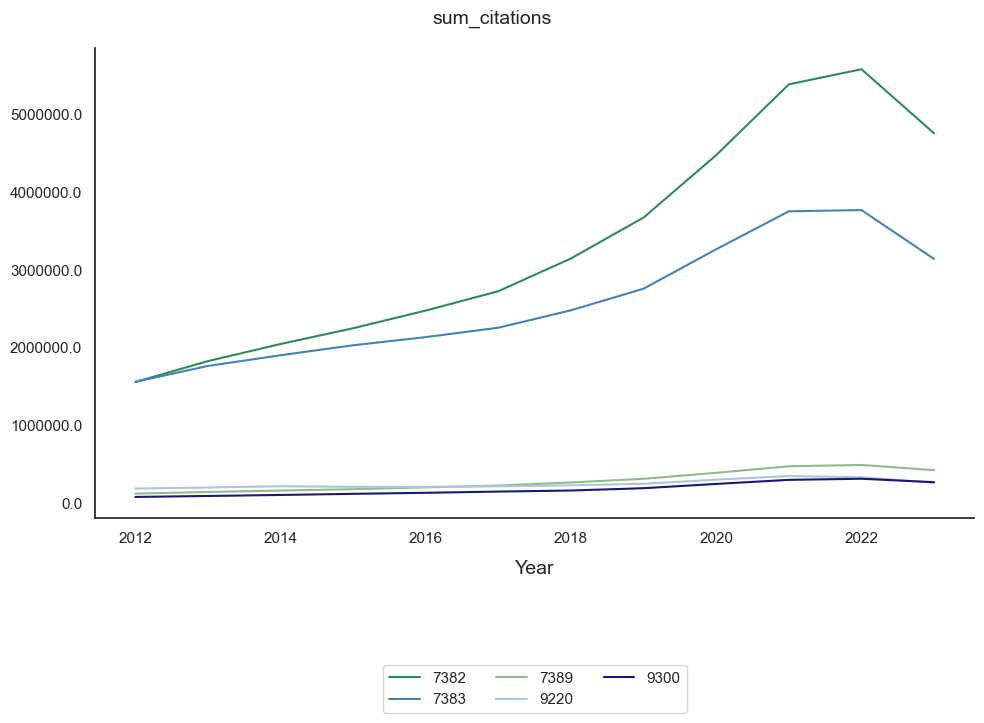

In [85]:
graph(to_plot, 'year', 'sum_citations', 'cat', [7382,7383,7389, 9220, 9300,7364])

In [62]:
siren.filter(func.col('siren')=='180089013').select('denominationUniteLegale','activitePrincipaleUniteLegale').show() # cnrs

+--------------+-----------------------------+
|nomUniteLegale|activitePrincipaleUniteLegale|
+--------------+-----------------------------+
|          NULL|                       72.19Z|
+--------------+-----------------------------+

